<a href="https://colab.research.google.com/github/LollaGavrishko/ML/blob/main/Lesson_5_Digits_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import time
import random
import numpy as np
#инициализацию random seed
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
import torchvision.datasets
#с помощью библиотеки torchvision.datasets, мы скачаем и train, и test, и получим соответственно mnist_train, mnist_test
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 63311305.45it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 34296629.06it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34145468.08it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14334483.65it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
X_train.dtype, y_train.dtype #  сначала посмотрим какие там типы

(torch.uint8, torch.int64)

In [ ]:
X_train = X_train.float()
X_test = X_test.float() # мы сразу преобразуем X_train и X_test во float (в дробные числа)

In [ ]:
X_train.shape, X_test.shape #X_train и X_test имеют размерности 60 тысяч изображений и 10 тысяч соответственно, и сами изображения (они размером 28 на 28) -
#- это очень маленькие картинки, поэтому мы и можем применять полносвязанную нейронную сеть для такой задачи

#X_train -- это многомерный тензор, y -- это одномерный (поэтому с маленькой)

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [ ]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

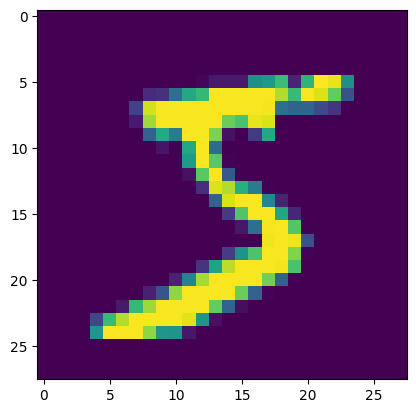

tensor(5)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0]) # импортировать matplotlib -- библиотеку для рисования графиков, там есть чудесная функция imshow и она может нарисовать картинку

In [ ]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28]) # растянуть эту картинку в один длинный вектор, и тогда каждый пиксель найдёт своё место в этом длинном векторе.

In [ ]:
#создадим такую нейронную сеть: она будет очень похожей на ту которую мы создавали для вин, она точно также будет состоять из нескольких полносвязанных слоёв.
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x

mnist_net = MNISTNet(100) # количество нейронов

In [ ]:
torch.cuda.is_available()

False

In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
list(mnist_net.parameters()) #

[Parameter containing:
 tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
         [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
         [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
         ...,
         [ 0.0221,  0.0258, -0.0088,  ..., -0.0141,  0.0051, -0.0318],
         [-0.0217, -0.0136,  0.0185,  ..., -0.0012, -0.0012, -0.0017],
         [ 0.0142,  0.0089, -0.0053,  ...,  0.0311, -0.0181,  0.0020]],
        requires_grad=True),
 Parameter containing:
 tensor([-3.5402e-02,  1.8178e-02, -2.1709e-02, -1.1839e-02,  4.8722e-03,
         -1.0492e-02, -1.9008e-02,  2.6994e-02, -3.4899e-02,  1.0381e-02,
         -3.5228e-02, -5.6381e-03, -2.0134e-02, -3.0264e-02, -1.3289e-02,
          2.5346e-02, -1.0797e-02,  2.1568e-03,  4.3630e-03, -2.1916e-02,
          2.2670e-02, -1.5766e-02,  3.4906e-02, -2.3063e-02, -6.8216e-03,
          2.7051e-02, -1.3991e-02,  9.7218e-03, -9.9075e-04,  1.6625e-03,
          2.3455e-02, -2.5294e-02,  4.80

In [ ]:
loss = torch.nn.CrossEntropyLoss() # функция потерь
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [ ]:
%time
# деление датасета на батчи, передаем их в нейронную сеть, подсчет градиентного спуска через forward
batch_size = 200

test_accuracy_history = []
test_loss_history = []
train_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
for epoch in range(100):
    order = np.random.permutation(len(X_train))

    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        preds = mnist_net.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).mean().cpu().detach().numpy())

    train_preds = mnist_net.forward(X_train)
    train_loss_history.append(loss(train_preds, y_train).mean().cpu().detach().numpy())

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().cpu()
    test_accuracy_history.append(accuracy.cpu().detach().numpy())
    print(accuracy)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10.7 µs
tensor(0.9114)
tensor(0.9224)
tensor(0.9259)
tensor(0.9255)
tensor(0.9324)
tensor(0.9316)
tensor(0.9339)
tensor(0.9347)
tensor(0.9373)
tensor(0.9389)
tensor(0.9450)
tensor(0.9366)
tensor(0.9402)
tensor(0.9417)
tensor(0.9466)
tensor(0.9464)
tensor(0.9403)
tensor(0.9448)
tensor(0.9409)
tensor(0.9458)
tensor(0.9480)
tensor(0.9483)
tensor(0.9456)
tensor(0.9506)
tensor(0.9514)
tensor(0.9480)
tensor(0.9528)
tensor(0.9510)
tensor(0.9527)
tensor(0.9514)
tensor(0.9491)
tensor(0.9499)
tensor(0.9525)
tensor(0.9508)
tensor(0.9517)
tensor(0.9494)
tensor(0.9532)
tensor(0.9510)
tensor(0.9533)
tensor(0.9506)
tensor(0.9552)
tensor(0.9586)
tensor(0.9544)
tensor(0.9543)
tensor(0.9557)
tensor(0.9539)
tensor(0.9564)
tensor(0.9536)
tensor(0.9592)
tensor(0.9593)
tensor(0.9515)
tensor(0.9553)
tensor(0.9539)
tensor(0.9576)
tensor(0.9557)
tensor(0.9552)
tensor(0.9537)
tensor(0.9565)
tensor(0.9560)
tensor(0.9560)
tensor(0.9559)
tensor(0.9574)
te

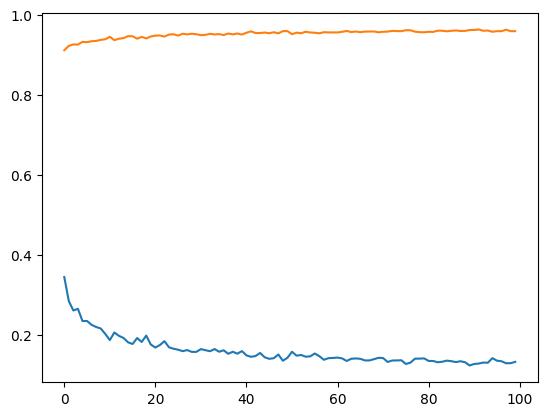

In [ ]:
# график accuracy и loss на валидации
plt.plot(test_loss_history)
plt.plot(test_accuracy_history)

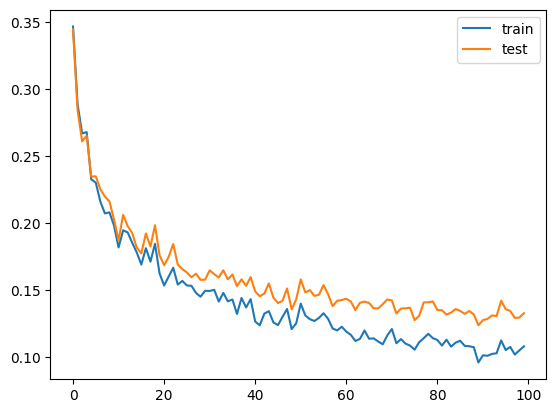

In [ ]:
# Постройте на одном графике loss для train и validation.
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')

plt.legend()

In [ ]:
Wall time: 7.39
Wall time: 10.7


SyntaxError: ignored